In [1]:
import torch
import numpy as np, cv2, pandas as pd, time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
trn_df = pd.read_csv('D:\pycharm\DL-Pytorch\Dataset\FairFace/fairface-labels-train.csv')
val_df = pd.read_csv('D:\pycharm\DL-Pytorch\Dataset\FairFace/fairface-labels-val.csv')
print(trn_df.head())

          file  age  gender        race  service_test
0  train/1.jpg   59    Male  East Asian          True
1  train/2.jpg   39  Female      Indian         False
2  train/3.jpg   11  Female       Black         False
3  train/4.jpg   26  Female      Indian          True
4  train/5.jpg   26  Female      Indian          True


In [3]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        filepath='D:\pycharm\DL-Pytorch\Dataset\FairFace/'+file
        im = cv2.imread(filepath)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen
    def preprocess_image(self, im):
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]
    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)

            ages.append(float(int(age)/80))
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages, genders

In [4]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

In [5]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)
a,b,c, = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
# torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


In [6]:
def get_model():
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
    model.classifier = ageGenderClassifier()
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(device), loss_functions, optimizer


In [7]:
model, loss_functions, optimizer = get_model()

D:\anaconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

In [9]:
def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
        pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae

In [10]:
model, criteria, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 10
best_test_loss = 1000
start = time.time()

In [11]:
for epoch in range(n_epochs):
    print(epoch)
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    for ix, data in enumerate(train_loader):
        # if ix == 100: break
        loss = train_batch(data, model, optimizer, criteria)
        epoch_train_loss += loss.item()
    for ix, data in enumerate(test_loader):
        # if ix == 10: break
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0])
    val_age_mae /= ctr
    val_gender_acc /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)
    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
    print(info)
    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)

0
1/10 (588.12s - 5881.24s remaining)
Epoch: 001	Train Loss: 0.552	Test: 0.466	Best Test Loss: 0.4664
Gender Accuracy: 83.60%	Age MAE: 6.05

1
2/10 (1158.76s - 5214.41s remaining)
Epoch: 002	Train Loss: 0.401	Test: 0.454	Best Test Loss: 0.4540
Gender Accuracy: 84.05%	Age MAE: 6.27

2
3/10 (1715.65s - 4575.08s remaining)
Epoch: 003	Train Loss: 0.287	Test: 0.520	Best Test Loss: 0.4540
Gender Accuracy: 84.39%	Age MAE: 6.18

3
4/10 (2264.40s - 3962.70s remaining)
Epoch: 004	Train Loss: 0.197	Test: 0.578	Best Test Loss: 0.4540
Gender Accuracy: 83.47%	Age MAE: 6.32

4
5/10 (2843.84s - 3412.61s remaining)
Epoch: 005	Train Loss: 0.155	Test: 0.699	Best Test Loss: 0.4540
Gender Accuracy: 83.39%	Age MAE: 6.24

5
6/10 (3404.59s - 2837.16s remaining)
Epoch: 006	Train Loss: 0.137	Test: 0.749	Best Test Loss: 0.4540
Gender Accuracy: 84.16%	Age MAE: 6.31

6
7/10 (3952.46s - 2258.55s remaining)
Epoch: 007	Train Loss: 0.124	Test: 0.822	Best Test Loss: 0.4540
Gender Accuracy: 83.77%	Age MAE: 6.28

7
8/10 

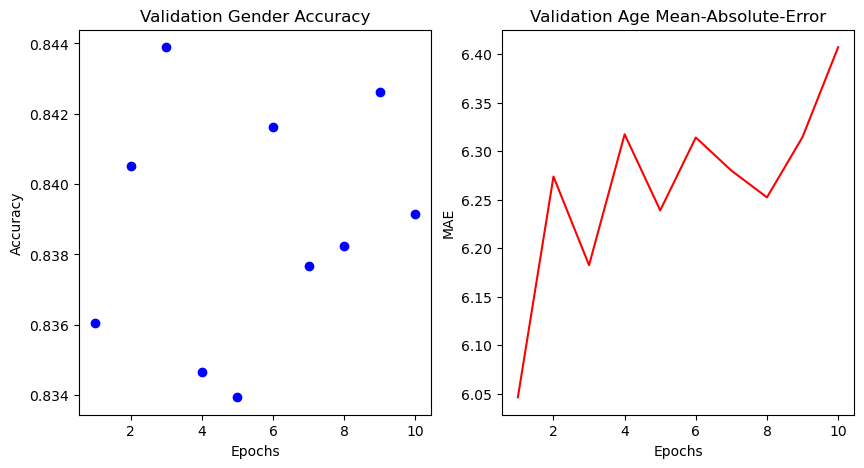

In [12]:
epochs = np.arange(1,len(val_gender_accuracies)+1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat

val_gender_accuracies = [x.cpu().item() if torch.is_tensor(x) else x for x in val_gender_accuracies]
val_age_maes = [x.cpu().item() if torch.is_tensor(x) else x for x in val_age_maes]

ax[0].plot(epochs, val_gender_accuracies, 'bo')
ax[1].plot(epochs, val_age_maes, 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[1].set_title('Validation Age Mean-Absolute-Error')
plt.show()

In [13]:
im = cv2.imread('D:\pycharm\DL-Pytorch\Dataset\FairFace/val/4.jpg')
im = trn.preprocess_image(im).to(device)

In [14]:
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

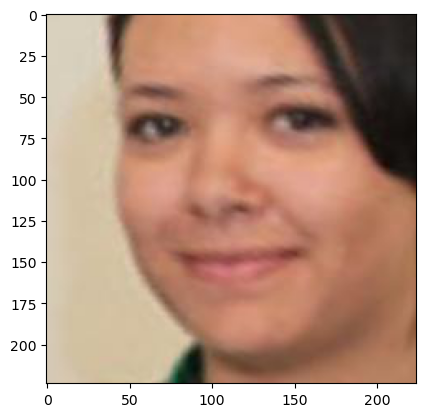

predicted gender: Male ; Predicted age 28


In [15]:
im = cv2.imread('D:\pycharm\DL-Pytorch\Dataset\FairFace/val/4.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))
# predicted gender: Female ; Predicted age 26